# 모델 특징 요약

- **기본 아이디어**:
  - 최적의 지역 희소 구조를 Dense components (밀집된 구성 요소) 로 가까스로 덮는 방법 찾기.
  - Translation invariance (변환 불변성) 가정: 네트워크는 convolutional building blocks (컨볼루션 빌딩 블록) 으로 구성.
  
- **인터넷/참조**:
  - Arora et al. [2]: 각 레이어의 상관 통계를 분석하여 고도로 상관된 유닛들을 클러스터링.
  - 각 레이어의 유닛은 input 이미지의 특정 영역에 대응.
- **하위 레이어 특징**:
  - 상관된 유닛들은 지역적으로 농축됨 → 1×1 컨볼루션 레이어로 커버.
  - 더 넓은 패치에서 컨볼루션으로 커버가능한 더 적은 수의 클러스터 가정.
- **현재 구조의 제한**:
  - 필터 크기: 1×1, 3×3, 5×5 → 편의성으로 제한.
  - 모든 레이어의 출력을 결합하여 다음 스테이지의 입력으로 사용.
  - 병렬 풀링 경로 (Pooling path)가 추가될 때 추가적인 이점 발생.
- **인셉션 모듈은 다음으로 구성**:
  - Naive version:
    - 1x1, 3x3, 5x5 컨볼루션 + 3x3 max pooling (그림 2(a)).
  - Dimension reduction version:
    - Dimension 감소 적용 → 1x1 컨볼루션 사용 (그림 2(b)).
    - 필터 간단한 거치기와 프로젝션 포함.
- **인셉션 네트워크 구조**:
  - 모듈이 서로 쌓임.
  - 각 스테이지에서 유닛 수를 증가시키고 연산 복잡도를 제어.
  - 여러 스테이지 단위에서의 정보 처리.
- **실용적 이점**:
  - 다양한 스케일에서 시각 정보 처리.
  - 적절한 수동 설계로 인한 연산 자원 조율 가능.


# Data Preparing

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop((224, 224), padding=4),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12500046.17it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

# Modeling

## Inception Module

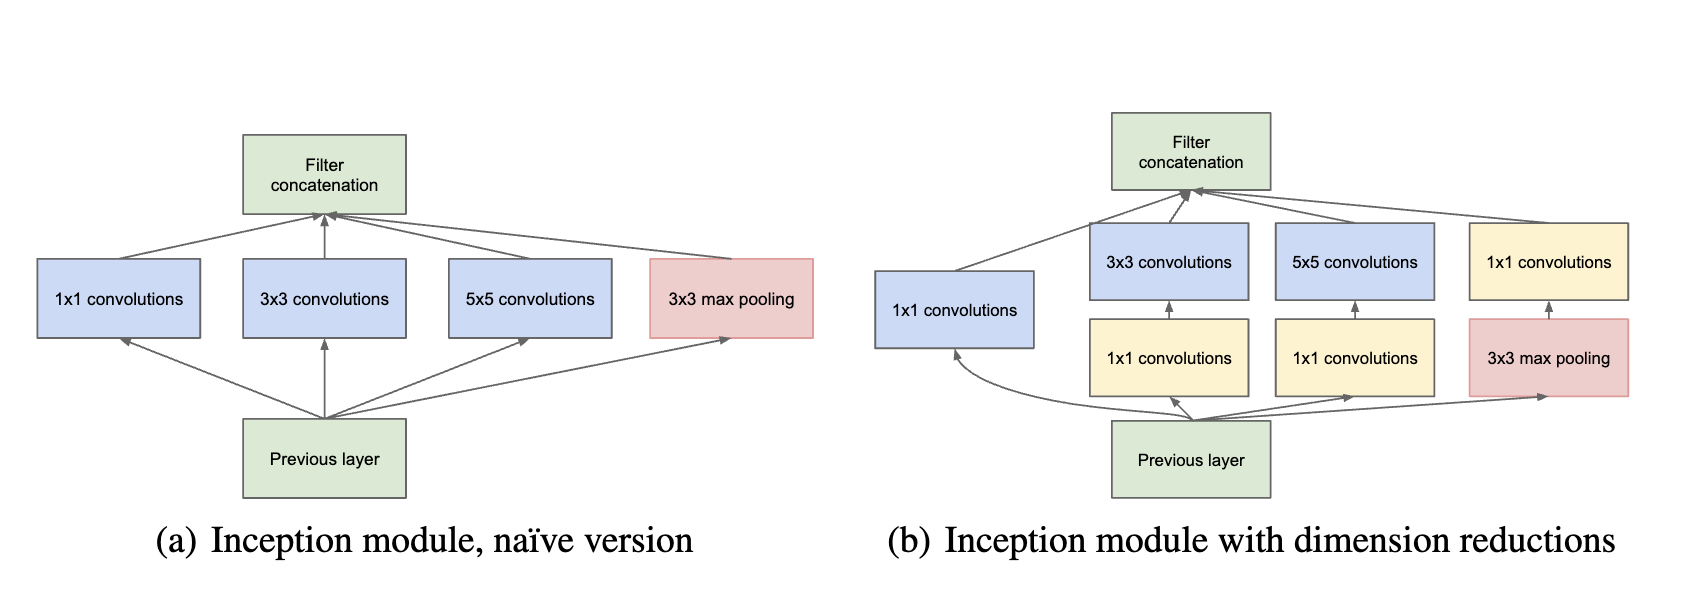

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Inception(nn.Module):
    def __init__(self, in_channels, out1x1, out3x3_reduce, out3x3, out5x5_reduce, out5x5, out_pool):
        super(Inception, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, out3x3_reduce, kernel_size=1),
            nn.Conv2d(out3x3_reduce, out3x3, kernel_size=3, padding=1)
        )

        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, out5x5_reduce, kernel_size=1),
            nn.Conv2d(out5x5_reduce, out5x5, kernel_size=5, padding=2)
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1x1(x)
        branch3 = self.branch3x3(x)
        branch5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        outputs = [branch1, branch3, branch5, branch_pool]
        return torch.cat(outputs, 1)


## GoogLeNet

In [5]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(192)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Training

In [6]:
import tqdm
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GoogLeNet(num_classes=10).to(device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    iterator = tqdm.tqdm(train_loader)
    model.train()
    for images, labels in iterator:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iterator.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [10/10], Loss: 22869.7617: 100%|██████████| 782/782 [02:58<00:00,  4.38it/s]


# Testing

In [8]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    iterator = tqdm.tqdm(test_loader)
    for images, labels in iterator:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'\nAccuracy of the model on the test images: {100 * correct / total:.2f}%')


100%|██████████| 157/157 [00:21<00:00,  7.19it/s]


Accuracy of the model on the test images: 17.97%
